# Multi-class Dog Breed Classification
Multiclass Dog Breed classification model build with TensorFlow and TensorFlow Hub

## 1. Problem
Given an image of a dog, asked to identify its breed.

## 2. Data
Data used is taken from Stanford University Dogs Dataset http://vision.stanford.edu/aditya86/ImageNetDogs/

## 3. Evaluation
The resultant model will be evaluated based on the Multi-class Log Loss.

## 4. Features
- Unstructured data (images)
- 120 Categories (dog breeds)
- Total of 20580 unique images.
- Approximately 150 images per breed.

# First, We Need to Prepare Libraries

In [1]:
#Import libraries
import tensorflow as tf
import tensorflow_hub as hub
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import datetime
print("TF version:", tf.__version__)
print("TF Hub version:", hub.__version__)

#Check whether theres GPU available
print("GPU", "available" if tf.config.list_physical_devices("GPU") else "not available")

TF version: 2.6.4
TF Hub version: 0.12.0
GPU available


2022-08-18 12:14:25.913675: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-18 12:14:26.040831: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-18 12:14:26.042099: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


# Data Preparation
## Retrieve the image classes (120 Unique Dog Breeds)

In [2]:
unique_breeds = []

for folders in os.listdir("../input/stanford-dogs-dataset/images/Images"):
    breed = "".join(folders.split("-")[1:])
    unique_breeds.append(breed)
    
# Converts to sorted ndarray
unique_breeds = np.array(sorted(unique_breeds))
len(unique_breeds), unique_breeds[:10]

(120,
 array(['Afghan_hound', 'African_hunting_dog', 'Airedale',
        'American_Staffordshire_terrier', 'Appenzeller',
        'Australian_terrier', 'Bedlington_terrier', 'Bernese_mountain_dog',
        'Blenheim_spaniel', 'Border_collie'], dtype='<U30'))

## Create a function to do all the pre-processing in one go (Data Pipeline)

In [3]:
IMG_SIZE = 224
BATCH_SIZE = 32

#Image Data Pipeline Function
def image_data_pipeline(path, augment=False, img_size=IMG_SIZE, batch_size=BATCH_SIZE, test_data=False, seed=42):
    """
    Reads images from path, and splits them into training and validation sets
    Create batches of data out of (image x) and (label y) pairs.
    Returns two data batches training_batch and validation_batch.

    Also accepts test data as input (no labels).
    """
    
    # Function for retrieving data
    def retrieve_data_from_path(path, test_data=False):
        filenames = []
        # Test data image retrieval (not separated per class)
        if test_data:
            for files in os.listdir(path):
                filenames.append(f"{path}/{files}")
            return np.array(filenames)
        
        # Train and val data image retrieval
        else:
            for folders in os.listdir(path):
                for files in os.listdir(f"{path}/{folders}"):
                    filenames.append(f"{path}/{folders}/{files}")
            filenames = np.array(filenames)
            np.random.shuffle(filenames)
            labels = np.array(["".join(name.split('/')[-2].split("-")[1:]) for name in filenames])
            unique_breeds = np.unique(labels)
            boolean_labels = np.array([label == unique_breeds for label in labels]).astype(int)
            return filenames, boolean_labels

    #Function for preprocessing
    def process_image(filename, img_size=IMG_SIZE):
        #read image
        image = tf.io.read_file(filename)

        #turn jpeg to numerical Tensor with 3 color channels (RGB)
        image = tf.image.decode_jpeg(image, channels=3)

        #Convert colour channels values 0-255 to 0-1 values.
        #This is a normalization process to make process more efficient.
        image = tf.image.convert_image_dtype(image, tf.float32)

        #Resize to (224,224)
        image = tf.image.resize(image, size=[img_size, img_size])

        return image
    
    # Function for data configuration (for performance) 
    def configure_tensor(ds, shuffle=False):
        if shuffle: # For train set
            ds = ds.shuffle(buffer_size=1000) 
        ds = ds.batch(batch_size)
        ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
        return ds
    
    augmentation = tf.keras.Sequential([
        tf.keras.layers.RandomRotation(0.1),
        tf.keras.layers.RandomTranslation(0.2, 0.2, fill_mode="nearest"),
        tf.keras.layers.RandomZoom(height_factor=0.2, width_factor=0.2),
        tf.keras.layers.RandomFlip(mode="horizontal")
    ])
    
    # ----------------------------------------------------------------------------------
    
    # Test data pipeline
    if test_data:
        print(f"Creating test data batches... BATCH SIZE={batch_size}")
        x = retrieve_data_from_path(path, test_data=True)
        x_test = tf.data.Dataset.from_tensor_slices(x).map(process_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
        return configure_tensor(x_test)
    
    # Train and validation data pipeline
    else:
        print(f"Creating train & validation data batches... BATCH SIZE={batch_size}")
        x, y = retrieve_data_from_path(path)
        x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.2, random_state=seed)
        x_train = tf.data.Dataset.from_tensor_slices(x_train).map(process_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
        x_valid = tf.data.Dataset.from_tensor_slices(x_valid).map(process_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
        if augment:
            x_train = x_train.map(augmentation, num_parallel_calls=tf.data.experimental.AUTOTUNE)
            x_valid = x_valid.map(augmentation, num_parallel_calls=tf.data.experimental.AUTOTUNE)
        y_train = tf.data.Dataset.from_tensor_slices(y_train)
        y_valid = tf.data.Dataset.from_tensor_slices(y_valid)
        train_data = tf.data.Dataset.zip((x_train, y_train)) 
        valid_data = tf.data.Dataset.zip((x_valid, y_valid)) 
        return configure_tensor(train_data, shuffle=True), configure_tensor(valid_data)
  

## Generate Train and Validation Data for Base Training (No augmentation)

In [4]:
path = "../input/stanford-dogs-dataset/images/Images"
train_data, valid_data = image_data_pipeline(path)
train_data.element_spec, valid_data.element_spec

2022-08-18 12:14:26.183154: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-18 12:14:26.183664: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-18 12:14:26.184663: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-18 12:14:26.185355: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

Creating train & validation data batches... BATCH SIZE=32


((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.int64, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.int64, name=None)))

## Visualize the generated image batches

2022-08-18 12:14:38.373500: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


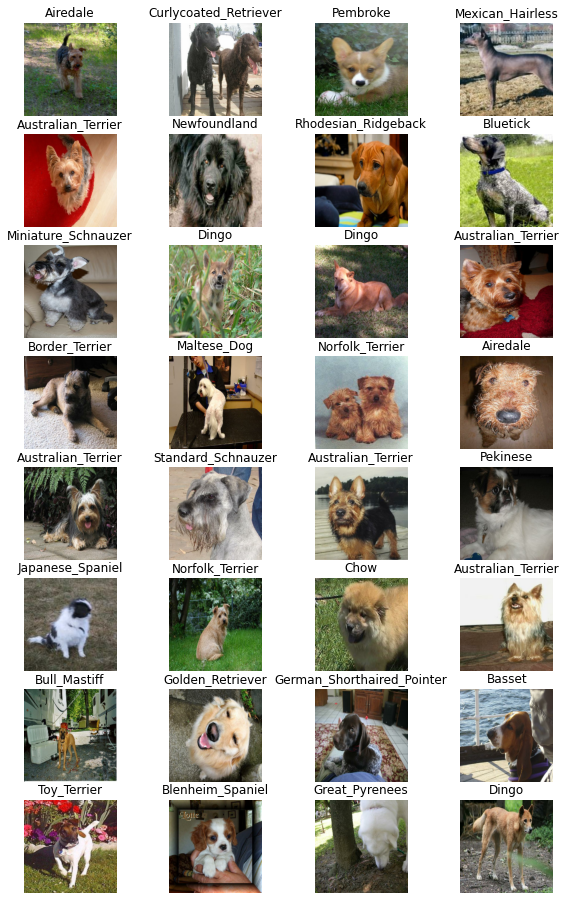

In [5]:
def show_batch(image_batch, label_batch):
  fig = plt.figure(figsize=(10,16))
  for n in range(BATCH_SIZE):
      ax = plt.subplot(8,4,n+1)
      plt.imshow(image_batch[n])
      plt.title(unique_breeds[label_batch[n]==1][0].title(), fontsize=12)
      plt.axis('off')
    
image_batch, label_batch = next(train_data.as_numpy_iterator())
show_batch(image_batch, label_batch)

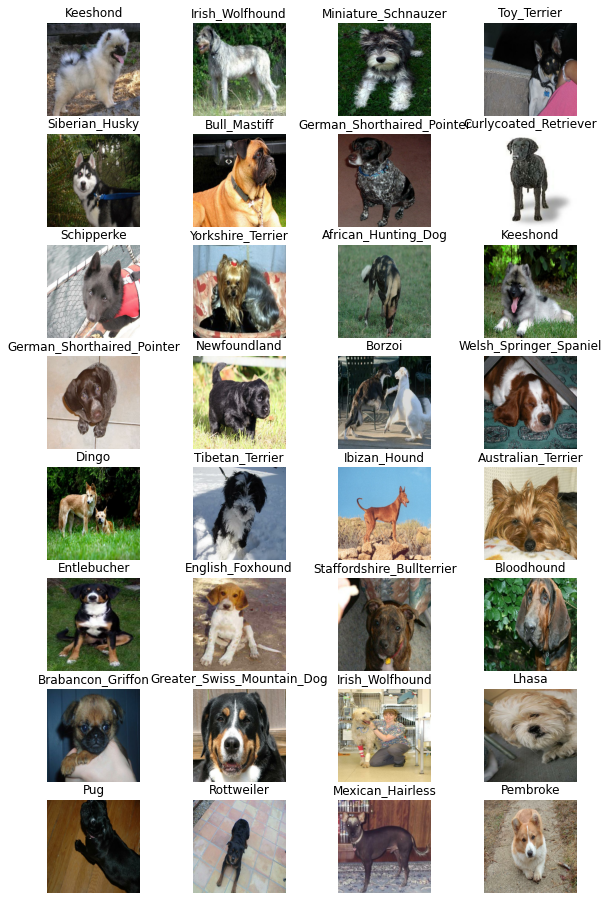

In [6]:
valid_image, valid_label = next(valid_data.as_numpy_iterator())
show_batch(valid_image, valid_label)

# Building a Model !

Before we build a model, there are a few things we need to define:
* The input shape (image shape in the form of Tensors)
* The output shape (image labels in the form of Tensors)
* URL of model we want to use Transfer Learning with from TensorFlow Hub
https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/classification/5

^^ MobileNetV3 ImageNet Feature Vectors (Size = 224x224, Depth Multiplier = 1.0)

In [6]:
#setup input shape into the model
INPUT_SHAPE = [None,IMG_SIZE, IMG_SIZE, 3] #batch, height, width, colour channel

#setup output shape of our model
OUTPUT_SHAPE = len(unique_breeds)

#setup model URL from Tensorflow HUB
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/feature_vector/5"

Now we've got our Inputs, Outputs, and Model ready...
Lets put them together into a Keras Deep Learning Model!

Knowing this, let's:
* Defines the layers of KEras Model in a sequential fashion
* Compiles the model (Says it should be evaluated and improved)
* Builds model (Tell model the input shape it'll be getting)

All the steps can be found in https://www.tensorflow.org/guide/keras/overview

In [7]:
# Extract Pre-trained base Model and freeze the layers
base_model = hub.KerasLayer("https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/feature_vector/5")
base_model.trainable = False
len(base_model.trainable_variables) # Shows that its frozen

0

In [8]:
# Setup Layers
model = tf.keras.Sequential([
    base_model, # Layer 1 (Input Layer)
    tf.keras.layers.Dense(units=512, activation="relu"), # Hidden Layer   
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=256, activation="relu"), # Hidden Layer       
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=OUTPUT_SHAPE, activation="softmax") # Layer 4 (Output Layer)       
])


# Compiling the model
base_learning_rate = 0.0001
model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
      metrics =["accuracy"]
)

# Build Model
model.build(INPUT_SHAPE)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              4226432   
_________________________________________________________________
dense (Dense)                (None, 512)               655872    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 120)               30840     
Total params: 5,044,472
Trainable params: 818,040
Non-trainable params: 4,226,432
______________________________________

In [12]:
len(model.trainable_variables)

6

## Creating Callbacks

Callbacks are helper functions a model can use during training to:
* Save its progress
* Check its progress
* Stop Training early if it stops improving

We'll create 2 callbacks,
- One is for Model Checkpoint, helps track and save our model
- Second is for early stopping, prevents model from training too long (becoming overfitted)

There is also a useful callback called TensorBoard but it is currently not working in Kaggle.
### TensorBoard Callback
https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard

To setup the Tensorboard Callback, we need to:
1. Load a TensorBoard notebook Extension
2. Create a Tensorboard Callback which save logs to a directory and pass it to the model's `fit()` function.
3. Visualize our models training logs with the `%tensorboard` magic function (we'll do this after model training)

### Model Checkpoint Callback
https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint

Callback to save the Keras model or model weights at some frequency.

In [9]:
def create_model_checkpoint(dir, suffix=None):
    modeldir = os.path.join(dir, "Models",
                          datetime.datetime.now().strftime("%Y_%m_%d-%H_%M_%s"))
    
    model_path = modeldir + "-" + suffix
    print(f"Model will be saved to `{model_path}`")
    return tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_accuracy',save_best_only=True)

### Early Stopping Callback
https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping

Helps model from overfitting by stopping training if a certain evaluation metric stops improving

In [10]:
# Create early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=10)

# Train the model
## NOW, lets train the mode with the full data (20580 images)

In [13]:
init_loss, init_acc = model.evaluate(valid_data)

2022-08-18 12:15:26.481455: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


129/129 [==============================] - 28s 158ms/step - loss: 4.8484 - accuracy: 0.0095


In [14]:
# Metrics before training (very poor performance)
print("initial loss: {:.2f}".format(init_loss))
print("initial accuracy: {:.2f}".format(init_acc))

initial loss: 4.85
initial accuracy: 0.01


In [15]:
# EPOCHS
NUM_EPOCHS = 100

# Create callback
checkpoint = create_model_checkpoint("Notebook_Outputs", "MobileNetV3_100_Adam_20580")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=10)

# Model Training
model_history = model.fit(x=train_data,
                    epochs=NUM_EPOCHS,
                    validation_data=valid_data,
                    validation_freq=1,
                    callbacks=[early_stopping, checkpoint],
                )

Model will be saved to `Notebook_Outputs/Models/2022_08_18-12_15_1660824958-MobileNetV3_100_Adam_20580`
Epoch 1/100
308/515 [================>.............] - ETA: 34s - loss: 3.8899 - accuracy: 0.2448

Cleanup called...


515/515 [==============================] - 98s 177ms/step - loss: 3.0298 - accuracy: 0.3972 - val_loss: 1.0147 - val_accuracy: 0.7668


2022-08-18 12:17:38.335699: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Epoch 2/100
309/515 [=================>............] - ETA: 16s - loss: 1.0425 - accuracy: 0.7240

Cleanup called...


515/515 [==============================] - 52s 96ms/step - loss: 0.9567 - accuracy: 0.7396 - val_loss: 0.6686 - val_accuracy: 0.8078
Epoch 3/100
309/515 [=================>............] - ETA: 16s - loss: 0.7361 - accuracy: 0.7833

Cleanup called...


515/515 [==============================] - 52s 96ms/step - loss: 0.7015 - accuracy: 0.7937 - val_loss: 0.6059 - val_accuracy: 0.8209
Epoch 4/100
309/515 [=================>............] - ETA: 16s - loss: 0.6031 - accuracy: 0.8146

Cleanup called...


515/515 [==============================] - 52s 97ms/step - loss: 0.5771 - accuracy: 0.8228 - val_loss: 0.5751 - val_accuracy: 0.8248
Epoch 5/100
309/515 [=================>............] - ETA: 17s - loss: 0.5189 - accuracy: 0.8409

Cleanup called...


515/515 [==============================] - 52s 98ms/step - loss: 0.4968 - accuracy: 0.8476 - val_loss: 0.5665 - val_accuracy: 0.8277
Epoch 6/100
309/515 [=================>............] - ETA: 16s - loss: 0.4490 - accuracy: 0.8596

Cleanup called...


515/515 [==============================] - 52s 96ms/step - loss: 0.4302 - accuracy: 0.8661 - val_loss: 0.5528 - val_accuracy: 0.8299
Epoch 7/100
309/515 [=================>............] - ETA: 17s - loss: 0.3908 - accuracy: 0.8776

Cleanup called...


515/515 [==============================] - 52s 98ms/step - loss: 0.3773 - accuracy: 0.8814 - val_loss: 0.5536 - val_accuracy: 0.8333
Epoch 8/100
309/515 [=================>............] - ETA: 17s - loss: 0.3471 - accuracy: 0.8939

Cleanup called...


515/515 [==============================] - 54s 99ms/step - loss: 0.3338 - accuracy: 0.8984 - val_loss: 0.5489 - val_accuracy: 0.8302
Epoch 9/100
309/515 [=================>............] - ETA: 17s - loss: 0.3114 - accuracy: 0.9051

Cleanup called...


515/515 [==============================] - 53s 98ms/step - loss: 0.2987 - accuracy: 0.9085 - val_loss: 0.5477 - val_accuracy: 0.8331
Epoch 10/100
309/515 [=================>............] - ETA: 16s - loss: 0.2775 - accuracy: 0.9154

Cleanup called...


515/515 [==============================] - 51s 95ms/step - loss: 0.2677 - accuracy: 0.9183 - val_loss: 0.5551 - val_accuracy: 0.8326
Epoch 11/100
309/515 [=================>............] - ETA: 16s - loss: 0.2541 - accuracy: 0.9224

Cleanup called...


515/515 [==============================] - 51s 95ms/step - loss: 0.2422 - accuracy: 0.9268 - val_loss: 0.5596 - val_accuracy: 0.8290
Epoch 12/100
309/515 [=================>............] - ETA: 16s - loss: 0.2223 - accuracy: 0.9332

Cleanup called...


515/515 [==============================] - 52s 96ms/step - loss: 0.2180 - accuracy: 0.9337 - val_loss: 0.5523 - val_accuracy: 0.8302
Epoch 13/100
309/515 [=================>............] - ETA: 16s - loss: 0.1979 - accuracy: 0.9427

Cleanup called...


515/515 [==============================] - 52s 97ms/step - loss: 0.1908 - accuracy: 0.9444 - val_loss: 0.5622 - val_accuracy: 0.8282
Epoch 14/100
309/515 [=================>............] - ETA: 16s - loss: 0.1808 - accuracy: 0.9454

Cleanup called...


515/515 [==============================] - 52s 97ms/step - loss: 0.1768 - accuracy: 0.9475 - val_loss: 0.5661 - val_accuracy: 0.8307
Epoch 15/100
309/515 [=================>............] - ETA: 16s - loss: 0.1595 - accuracy: 0.9551

Cleanup called...


515/515 [==============================] - 51s 95ms/step - loss: 0.1537 - accuracy: 0.9561 - val_loss: 0.5656 - val_accuracy: 0.8319
Epoch 16/100
309/515 [=================>............] - ETA: 17s - loss: 0.1479 - accuracy: 0.9551

Cleanup called...


515/515 [==============================] - 52s 98ms/step - loss: 0.1416 - accuracy: 0.9580 - val_loss: 0.5698 - val_accuracy: 0.8280
Epoch 17/100
309/515 [=================>............] - ETA: 17s - loss: 0.1279 - accuracy: 0.9653

Cleanup called...


515/515 [==============================] - 52s 98ms/step - loss: 0.1251 - accuracy: 0.9647 - val_loss: 0.5817 - val_accuracy: 0.8311


## Model Learning Curves (Accuracy/Loss)

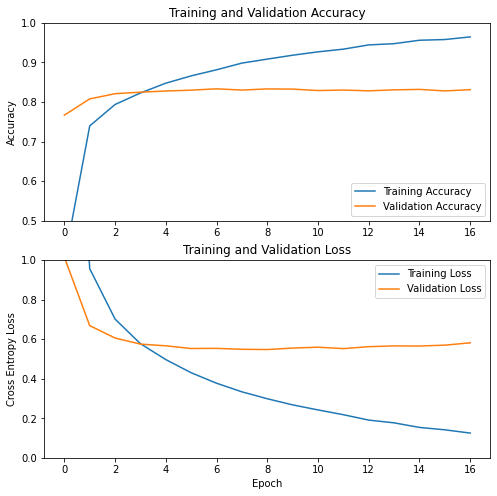

In [16]:
def plot_learning_curves(model_history):
    # retrieve learning metrics history 
    acc = model_history.history['accuracy']
    val_acc = model_history.history['val_accuracy']
    loss = model_history.history['loss']
    val_loss =model_history.history['val_loss']

    # Plot
    fig = plt.figure(figsize=(8,8))
    ax_acc = plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel("Accuracy")
    plt.ylim([0.5, 1])
    plt.title("Training and Validation Accuracy",)
    
    ax_loss = plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy Loss')
    plt.ylim([0,1.0])
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.show()

plot_learning_curves(model_history)

In [17]:
load_model = tf.keras.models.load_model("Notebook_Outputs/Models/2022_08_18-12_15_1660824958-MobileNetV3_100_Adam_20580")
base_loss, base_acc = load_model.evaluate(valid_data) #5814 8399

129/129 [==============================] - 11s 77ms/step - loss: 0.5536 - accuracy: 0.8333


In [18]:
# Metrics after training (decent performance)
print("{0:<10}|  {1:<10}{2:<10}".format("METRICS", "INITIAL", "TRAINED"))
print("-"*30)
print("{0:<10}|  {1:<10.5f}{2:<10.5f}".format("Accuracy", init_acc, base_acc))
print("{0:<10}|  {1:<10.5f}{2:<10.5f}".format("Loss", init_loss, base_loss))

METRICS   |  INITIAL   TRAINED   
------------------------------
Accuracy  |  0.00948   0.83333   
Loss      |  4.84844   0.55357   


# Data Augmentation

In [19]:
path = "../input/stanford-dogs-dataset/images/Images"
augment_train_data, augment_valid_data = image_data_pipeline(path, augment=True)
augment_train_data.element_spec, augment_valid_data.element_spec

Creating train & validation data batches... BATCH SIZE=32


((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.int64, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.int64, name=None)))

2022-08-18 12:39:27.076308: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 895 of 1000
2022-08-18 12:39:28.245804: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


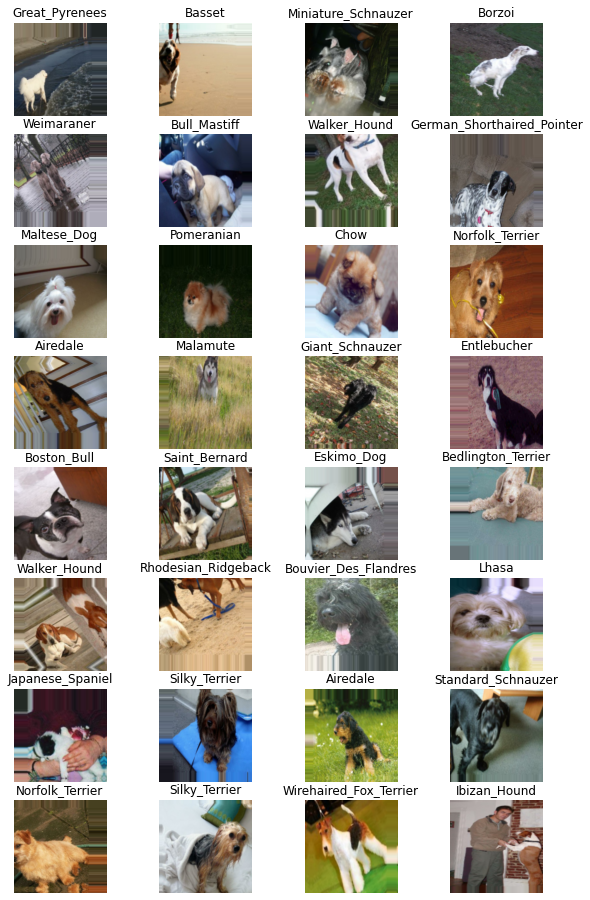

In [20]:
augment_train_image, augment_train_label = next(augment_train_data.as_numpy_iterator())
show_batch(augment_train_image, augment_train_label)

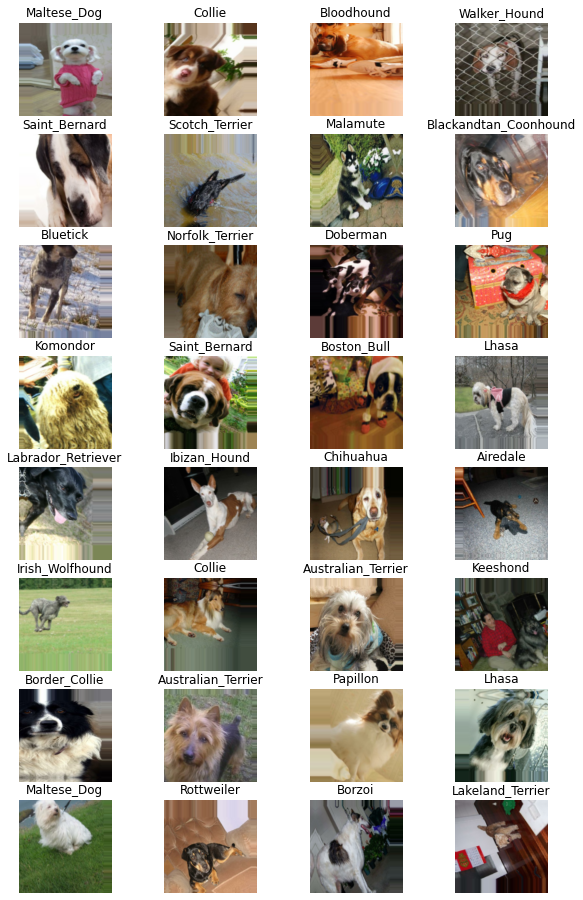

In [34]:
augment_val_image, augment_val_label = next(augment_valid_data.as_numpy_iterator())
show_batch(augment_val_image, augment_val_label)

In [21]:
# Create callback
checkpoint = create_model_checkpoint("Notebook_Outputs", "MobileNetV2_100_Adam_20580_Augmented")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=10)

# Model Training
model_history_augment = load_model.fit(augment_train_data,
                             epochs=NUM_EPOCHS,
                             validation_data=augment_valid_data,
                             validation_freq=1,
                             callbacks=[early_stopping, checkpoint]
                              )

Model will be saved to `Notebook_Outputs/Models/2022_08_18-12_49_1660826996-MobileNetV2_100_Adam_20580_Augmented`
Epoch 1/100


2022-08-18 12:50:12.533189: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 938 of 1000
2022-08-18 12:50:13.213848: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


514/515 [============================>.] - ETA: 0s - loss: 1.1090 - accuracy: 0.6887

Cleanup called...


515/515 [==============================] - 239s 432ms/step - loss: 1.1093 - accuracy: 0.6887 - val_loss: 0.8829 - val_accuracy: 0.7413
Epoch 2/100


2022-08-18 12:54:34.443588: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 958 of 1000
2022-08-18 12:54:34.929556: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


514/515 [============================>.] - ETA: 0s - loss: 1.0208 - accuracy: 0.7089

Cleanup called...


515/515 [==============================] - 232s 429ms/step - loss: 1.0210 - accuracy: 0.7088 - val_loss: 0.8677 - val_accuracy: 0.7451
Epoch 3/100


2022-08-18 12:58:30.790486: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 883 of 1000
2022-08-18 12:58:32.074718: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


514/515 [============================>.] - ETA: 0s - loss: 0.9629 - accuracy: 0.7198

Cleanup called...


515/515 [==============================] - 231s 427ms/step - loss: 0.9631 - accuracy: 0.7199 - val_loss: 0.8591 - val_accuracy: 0.7488
Epoch 4/100


2022-08-18 13:02:52.699638: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 885 of 1000
2022-08-18 13:02:53.927641: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


514/515 [============================>.] - ETA: 0s - loss: 0.9175 - accuracy: 0.7316

Cleanup called...


515/515 [==============================] - 233s 431ms/step - loss: 0.9180 - accuracy: 0.7315 - val_loss: 0.8274 - val_accuracy: 0.7524
Epoch 5/100


2022-08-18 13:06:50.408709: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 979 of 1000
2022-08-18 13:06:50.619266: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


514/515 [============================>.] - ETA: 0s - loss: 0.8741 - accuracy: 0.7412

Cleanup called...


515/515 [==============================] - 230s 427ms/step - loss: 0.8740 - accuracy: 0.7412 - val_loss: 0.8622 - val_accuracy: 0.7437
Epoch 6/100


2022-08-18 13:11:12.325293: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 884 of 1000
2022-08-18 13:11:13.561920: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


514/515 [============================>.] - ETA: 0s - loss: 0.8475 - accuracy: 0.7504

Cleanup called...


515/515 [==============================] - 230s 426ms/step - loss: 0.8476 - accuracy: 0.7504 - val_loss: 0.8326 - val_accuracy: 0.7527
Epoch 7/100


2022-08-18 13:15:08.243658: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 919 of 1000
2022-08-18 13:15:09.121438: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


514/515 [============================>.] - ETA: 0s - loss: 0.8059 - accuracy: 0.7605

Cleanup called...


515/515 [==============================] - 230s 426ms/step - loss: 0.8060 - accuracy: 0.7605 - val_loss: 0.8059 - val_accuracy: 0.7580
Epoch 8/100


2022-08-18 13:19:03.257327: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 946 of 1000
2022-08-18 13:19:03.896231: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


514/515 [============================>.] - ETA: 0s - loss: 0.7808 - accuracy: 0.7640

Cleanup called...


515/515 [==============================] - 231s 427ms/step - loss: 0.7815 - accuracy: 0.7639 - val_loss: 0.8525 - val_accuracy: 0.7536
Epoch 9/100


2022-08-18 13:23:25.174680: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 852 of 1000
2022-08-18 13:23:26.730745: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


514/515 [============================>.] - ETA: 0s - loss: 0.7496 - accuracy: 0.7764

Cleanup called...


515/515 [==============================] - 230s 424ms/step - loss: 0.7499 - accuracy: 0.7762 - val_loss: 0.8511 - val_accuracy: 0.7483
Epoch 10/100


2022-08-18 13:27:14.999986: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 879 of 1000
2022-08-18 13:27:16.282993: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


514/515 [============================>.] - ETA: 0s - loss: 0.7365 - accuracy: 0.7788

Cleanup called...


515/515 [==============================] - 229s 423ms/step - loss: 0.7366 - accuracy: 0.7787 - val_loss: 0.8532 - val_accuracy: 0.7539
Epoch 11/100


2022-08-18 13:31:04.230382: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 975 of 1000
2022-08-18 13:31:04.494851: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


514/515 [============================>.] - ETA: 0s - loss: 0.7251 - accuracy: 0.7781

Cleanup called...


515/515 [==============================] - 228s 423ms/step - loss: 0.7252 - accuracy: 0.7781 - val_loss: 0.8497 - val_accuracy: 0.7466
Epoch 12/100


2022-08-18 13:35:26.152597: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 978 of 1000
2022-08-18 13:35:26.372284: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


514/515 [============================>.] - ETA: 0s - loss: 0.7018 - accuracy: 0.7857

Cleanup called...


515/515 [==============================] - 229s 425ms/step - loss: 0.7017 - accuracy: 0.7857 - val_loss: 0.8520 - val_accuracy: 0.7413
Epoch 13/100


2022-08-18 13:39:48.065203: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 970 of 1000
2022-08-18 13:39:48.365675: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


514/515 [============================>.] - ETA: 0s - loss: 0.6648 - accuracy: 0.7984

Cleanup called...


515/515 [==============================] - 228s 422ms/step - loss: 0.6645 - accuracy: 0.7985 - val_loss: 0.8355 - val_accuracy: 0.7549
Epoch 14/100


2022-08-18 13:43:35.766864: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 954 of 1000
2022-08-18 13:43:36.264503: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


514/515 [============================>.] - ETA: 0s - loss: 0.6620 - accuracy: 0.7990

Cleanup called...


515/515 [==============================] - 229s 425ms/step - loss: 0.6622 - accuracy: 0.7989 - val_loss: 0.8498 - val_accuracy: 0.7454
Epoch 15/100


2022-08-18 13:47:25.283257: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 957 of 1000
2022-08-18 13:47:25.731707: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


514/515 [============================>.] - ETA: 0s - loss: 0.6421 - accuracy: 0.8017

Cleanup called...


515/515 [==============================] - 228s 422ms/step - loss: 0.6416 - accuracy: 0.8019 - val_loss: 0.8226 - val_accuracy: 0.7529
Epoch 16/100


2022-08-18 13:51:47.220750: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 960 of 1000
2022-08-18 13:51:47.621302: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


514/515 [============================>.] - ETA: 0s - loss: 0.6238 - accuracy: 0.8083

Cleanup called...


515/515 [==============================] - 229s 424ms/step - loss: 0.6239 - accuracy: 0.8083 - val_loss: 0.8583 - val_accuracy: 0.7456
Epoch 17/100


2022-08-18 13:56:09.119270: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 904 of 1000
2022-08-18 13:56:10.242049: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


514/515 [============================>.] - ETA: 0s - loss: 0.6133 - accuracy: 0.8130

Cleanup called...


515/515 [==============================] - 229s 423ms/step - loss: 0.6132 - accuracy: 0.8130 - val_loss: 0.8470 - val_accuracy: 0.7549


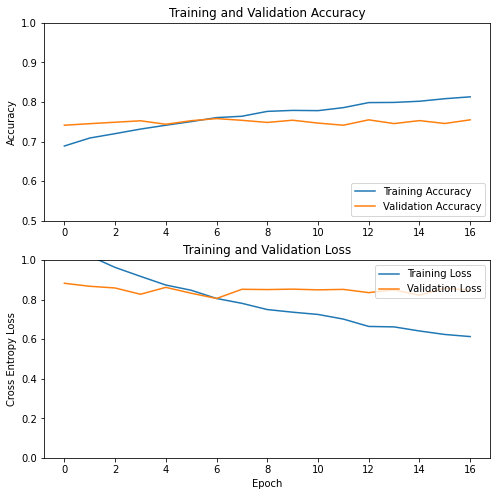

In [22]:
plot_learning_curves(model_history_augment)

In [26]:
load_model = tf.keras.models.load_model("Notebook_Outputs/Models/2022_08_18-12_15_1660824958-MobileNetV3_100_Adam_20580")
base_loss, base_acc = load_model.evaluate(valid_data)
base_augloss, base_augacc = load_model.evaluate(augment_valid_data)
load_model_augment = tf.keras.models.load_model("Notebook_Outputs/Models/2022_08_18-12_49_1660826996-MobileNetV2_100_Adam_20580_Augmented")
aug_loss, aug_acc = load_model_augment.evaluate(valid_data) 
aug_augloss, aug_augacc = load_model_augment.evaluate(augment_valid_data)

 18/129 [===>..........................] - ETA: 40s - loss: 1.0339 - accuracy: 0.7257

Cleanup called...


 18/129 [===>..........................] - ETA: 43s - loss: 0.8610 - accuracy: 0.7535

Cleanup called...


129/129 [==============================] - 47s 363ms/step - loss: 0.8489 - accuracy: 0.7507


In [29]:
# Metrics after augmented training
print("{0:<13}|  {1:<10}{2:<10}{3:<10}".format("METRICS", "INITIAL", "TRAINED", "AUGMENT"))
print("-"*43)
print("{0:<13}|  {1:<10.5f}{2:<10.5f}{3:<10.5f}".format("Accuracy", init_acc, base_acc, aug_acc))
print("{0:<13}|  {1:^10}{2:<10.5f}{3:<10.5f}".format("Aug-Accuracy", "-", base_augacc, aug_augacc))
print("{0:<13}|  {1:<10.5f}{2:<10.5f}{3:<10.5f}".format("Loss", init_loss, base_loss, aug_loss))
print("{0:<13}|  {1:^10}{2:<10.5f}{3:<10.5f}".format("Aug-Loss", "-", base_augloss, aug_augloss))

METRICS      |  INITIAL   TRAINED   AUGMENT   
-------------------------------------------
Accuracy     |  0.00948   0.83333   0.87051   
Aug-Accuracy |      -     0.72838   0.75073   
Loss         |  4.84844   0.55357   0.41024   
Aug-Loss     |      -     0.94575   0.84889   


## Make a prediction using the trained model and evaluate VISUALLY

In [40]:
# Make Predictions on validation data (not trained on)
preds = load_model_augment.predict(valid_data, verbose=1)
preds

129/129 [==============================] - 10s 72ms/step


array([[3.5435655e-06, 9.3711960e-10, 3.0883925e-08, ..., 2.2815234e-09,
        4.5723645e-08, 2.4901454e-09],
       [2.6323096e-07, 1.6797735e-09, 1.3082890e-05, ..., 2.1433512e-07,
        4.0678118e-05, 3.0797985e-03],
       [2.1741464e-06, 1.5575451e-07, 1.9826339e-06, ..., 2.8686252e-08,
        1.7543720e-06, 2.7751497e-07],
       ...,
       [3.2473163e-05, 1.2724311e-06, 5.0763546e-08, ..., 3.2120653e-07,
        3.6041745e-06, 7.3875739e-08],
       [1.8567803e-04, 2.8938109e-06, 2.3377361e-04, ..., 2.4657295e-04,
        1.2176290e-05, 5.3810527e-06],
       [5.2194700e-05, 3.6303209e-06, 1.6811922e-05, ..., 7.4928162e-06,
        5.7927996e-06, 1.1769123e-06]], dtype=float32)

In [41]:
# Lets make a function that convert the array of numbers into a label prediction...
def get_pred_label(prediction_probabilities):
  """
  Turns an array of prediction probabilities into a label.
  """
  return unique_breeds[np.argmax(prediction_probabilities)]

get_pred_label(preds[0])

'Great_Pyrenees'

In [42]:
unbatched_image, unbatched_label = next(valid_data.as_numpy_iterator())
unbatched_image[0], unbatched_label[0]

(array([[[0.4534655 , 0.4260145 , 0.38679883],
         [0.45724863, 0.42979765, 0.39058197],
         [0.4792426 , 0.4517916 , 0.41257593],
         ...,
         [0.24620563, 0.2148331 , 0.14032328],
         [0.23927966, 0.20790711, 0.1333973 ],
         [0.22767015, 0.1962976 , 0.12178779]],
 
        [[0.47386417, 0.4464132 , 0.4071975 ],
         [0.45655006, 0.42909908, 0.3898834 ],
         [0.47494924, 0.44749826, 0.40828258],
         ...,
         [0.17676826, 0.14539571, 0.07088591],
         [0.1757742 , 0.14440165, 0.06989186],
         [0.18865702, 0.15728447, 0.08277467]],
 
        [[0.4834886 , 0.4560376 , 0.41682193],
         [0.50602245, 0.47857147, 0.4393558 ],
         [0.48019382, 0.45274284, 0.41352716],
         ...,
         [0.23906706, 0.19592981, 0.12534156],
         [0.2440495 , 0.20091225, 0.130324  ],
         [0.2526384 , 0.20950113, 0.13891289]],
 
        ...,
 
        [[0.5451016 , 0.4313761 , 0.40000355],
         [0.54631126, 0.43258572, 0.40121

In [44]:
# Personal function to check accuracy of prediction
def preds_check(index=0,preds=preds, verbose=False):
  if verbose:
    print(preds[index])
  print(f"Max value (probability of prediction) : {np.max(preds[index])}")
  print(f"Sum : {np.sum(preds[index])}")
  print(f"Max Index: {np.argmax(preds[index])}")
  print(f"Predicted label: {get_pred_label(preds[index])}")
  print(f"Actual label: {get_pred_label(unbatched_label[index])}")

In [45]:
preds_check(0)

Max value (probability of prediction) : 0.9957554340362549
Sum : 1.0
Max Index: 30
Predicted label: Great_Pyrenees
Actual label: Great_Pyrenees


In [46]:
def plot_pred(prediction_probabilities, labels, images, n=1):
  """
  View the prediction, ground truth and image for sample n
  """
  pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]

  # Get pred label
  pred_label = get_pred_label(pred_prob)
  true_label = get_pred_label(true_label)

  # Plot image
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])

  # Change color if right or wrong
  if pred_label == true_label:
    color = "green"
  else:
    color = "red"
  # Change plot title to predicted, prob predicted, truth label
  plt.title("{} / {:2.2f}% / {}".format(pred_label, 
                                        np.max(pred_prob)*100,
                                        true_label),
            color=color)

    
def plot_pred_conf(prediction_probabilities, labels, n=1):
  """
  Plots the top 10 highest prediction confidences along with truth label for sample n.
  """
  pred_prob, true_label = prediction_probabilities[n], get_pred_label(labels[n])

  # Get predicted label
  pred_label = get_pred_label(pred_prob)

  # Find top 10 prediction confidence indexes
  top_10_pred_index = pred_prob.argsort()[-10:][::-1]
  # Find top 10 prediction confidence values
  top_10_pred_value = pred_prob[top_10_pred_index]
  # Find top 10 prediction labels
  top_10_pred_labels = unique_breeds[top_10_pred_index]

  # Plot
  top_plot = plt.bar(np.arange(len(top_10_pred_labels)),
                     top_10_pred_value,
                     color="grey")
  plt.xticks(np.arange(len(top_10_pred_labels)),
             labels=top_10_pred_labels,
             rotation="vertical")

  # Change color
  if np.isin(true_label, top_10_pred_labels).any():
    print("Truth Label = ", true_label)
    top_plot[np.argmax(top_10_pred_labels == true_label)].set_color("green")

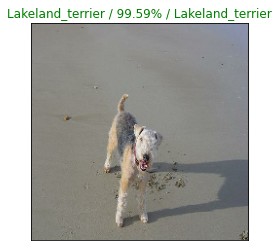

In [76]:
plot_pred(preds,unbatched_label,unbatched_image, 1)

Truth Label =  dhole


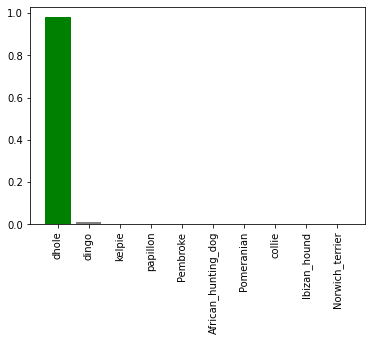

In [48]:
plot_pred_conf(preds, unbatched_label, 10)

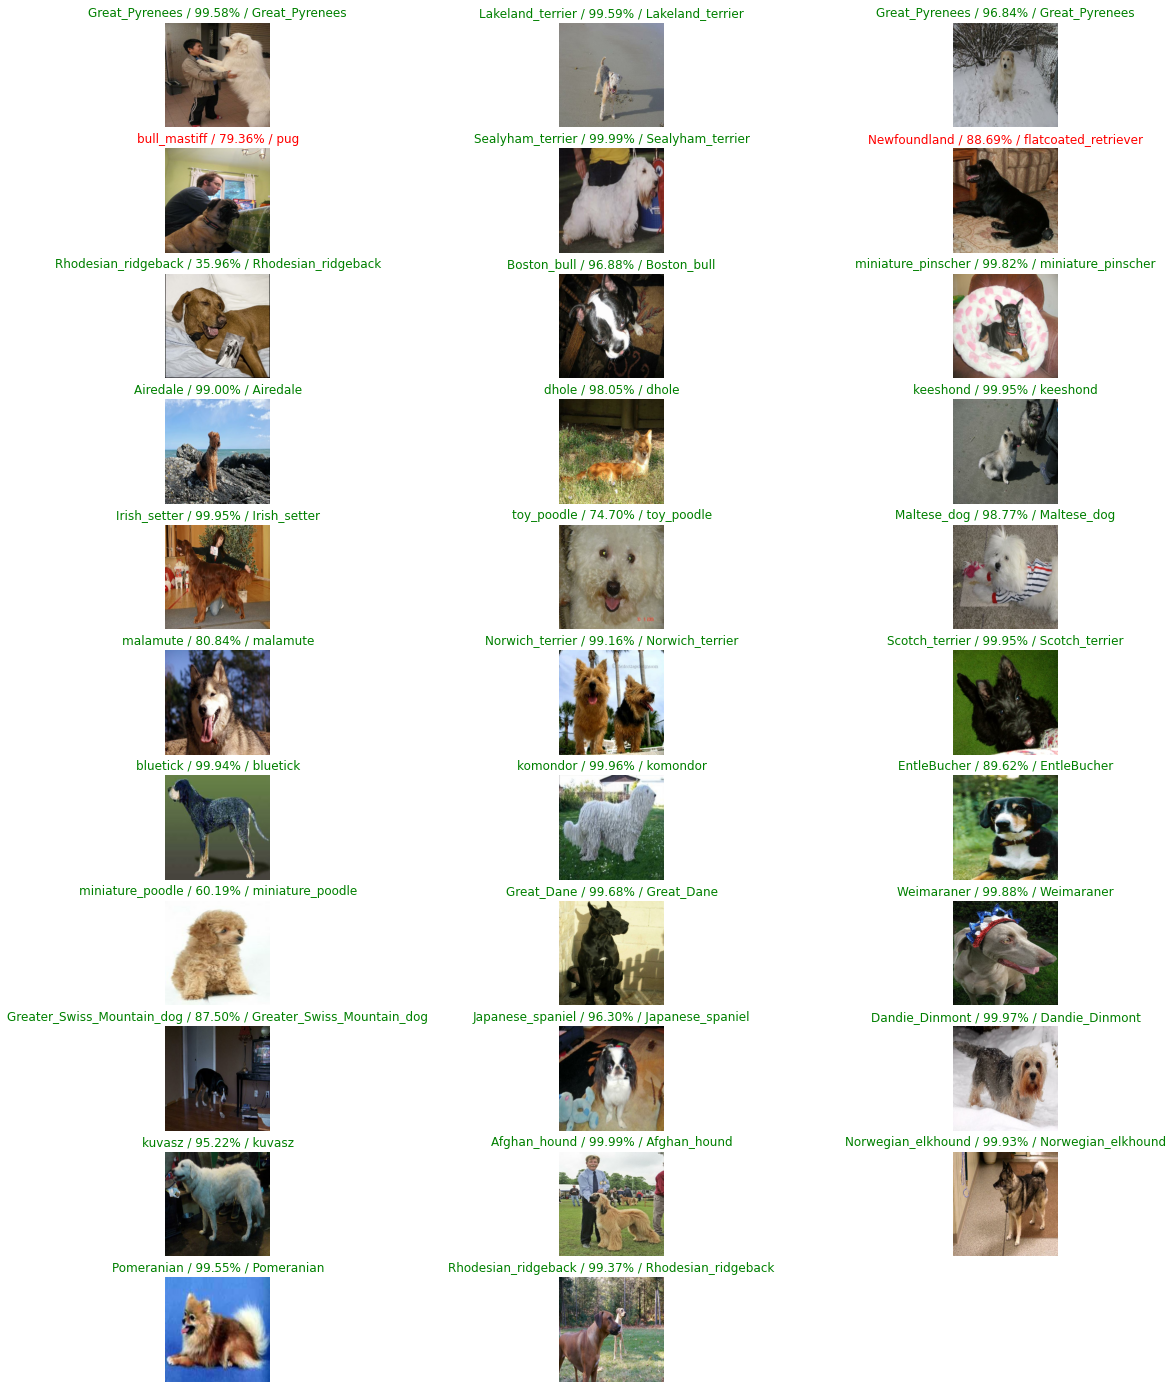

In [93]:
def plot_preds_batch(preds, label, image):
  fig = plt.figure(figsize=(20,25))
  for n in range(BATCH_SIZE):
    ax = plt.subplot(11,3,n+1)
    plot_pred(preds,label,image, n)
    plt.axis('off')
plot_preds_batch(preds, unbatched_label, unbatched_image)

## Reloading a trained model

In [49]:
# Create a function to load model
def load_model(model_path):
  """
  Loads a saved model from a specified path
  """
  print(f"Loading saved model from: {model_path}")
  model = tf.keras.models.load_model(model_path,
                                     custom_objects={"KerasLayer" : hub.KerasLayer})
  return model

In [50]:
# Load a model trained on 1200 images
new_model = load_model("Notebook_Outputs/Models/2022_08_18-12_49_1660826996-MobileNetV2_100_Adam_20580_Augmented")

Loading saved model from: Notebook_Outputs/Models/2022_08_18-12_49_1660826996-MobileNetV2_100_Adam_20580_Augmented


In [53]:
new_model.evaluate(valid_data)
new_model.evaluate(train_data)

new_model.evaluate(augment_valid_data)
new_model.evaluate(augment_train_data)

309/515 [=================>............] - ETA: 17s - loss: 0.2245 - accuracy: 0.9295

Cleanup called...


 18/129 [===>..........................] - ETA: 37s - loss: 0.8706 - accuracy: 0.7431

Cleanup called...


129/129 [==============================] - 46s 350ms/step - loss: 0.8430 - accuracy: 0.7483


2022-08-18 14:23:55.485037: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 942 of 1000
2022-08-18 14:23:56.347912: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


515/515 [==============================] - 185s 338ms/step - loss: 0.6023 - accuracy: 0.8236


[0.6022763252258301, 0.8236151337623596]